# Predicting the sale price of bulldozers using Machine Learning

Goal: Predict the saleprice of bulldozers

## 1. Problem defenition
* How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of similar bulldozers have been sold for?
## 2. Data
* From kaggle Bluebook for bulldozers competition

There are 3 main datasets:
* **Train.csv** is the training set, which contains data through the end of 2011.
* **Valid.csv** is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* **Test.csv** is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.
## 3. Evaluation
* Mnimise RMSLE (root mean squared log error) between the actual and predicted auction prices.
## 4. Feartures
* Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary on Google Sheets: https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

Download the data from github repository

In [9]:
!wget https://github.com/mrdbourke/zero-to-mastery-ml/raw/master/data/bluebook-for-bulldozers.zip # download files from GitHub as zip

import os
import zipfile

local_zip = 'bluebook-for-bulldozers.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('.') # extract all data into current working directory
zip_ref.close()

--2022-07-27 08:46:29--  https://github.com/mrdbourke/zero-to-mastery-ml/raw/master/data/bluebook-for-bulldozers.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/zero-to-mastery-ml/master/data/bluebook-for-bulldozers.zip [following]
--2022-07-27 08:46:29--  https://raw.githubusercontent.com/mrdbourke/zero-to-mastery-ml/master/data/bluebook-for-bulldozers.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72077822 (69M) [application/zip]
Saving to: ‘bluebook-for-bulldozers.zip.1’

bluebook-for-bulldo 100%[===================>]  68.74M   193MB/s    in 0.4s    

2022-07-27 08:46:30 (1

In [10]:
# Import training and validation sets
df = pd.read_csv("bluebook-for-bulldozers/TrainAndValid.csv",
                 low_memory=False)

In [11]:
df.head(1)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional


In [12]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

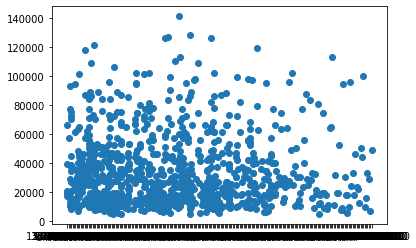

In [18]:
fig,ax = plt.subplots()
ax.scatter(df["saledate"][:1000],df["SalePrice"][:1000]);

Text(0.5, 1.0, 'Price x Frequency')

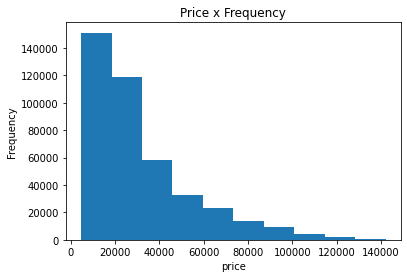

In [22]:
df.SalePrice.plot(kind="hist");
plt.xlabel("price")
plt.title("Price x Frequency")

### Parsing dates
When we work with time series data, we want to enrich the time and date component.

We can do that by telling pandas which of our column has dates in it. using `parse_dates` paramater.

In [23]:
# Import data but parse dates
df = pd.read_csv("bluebook-for-bulldozers/TrainAndValid.csv",
                 low_memory=False,parse_dates=["saledate"])

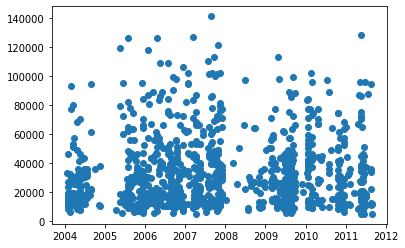

In [24]:
fig,ax = plt.subplots()
ax.scatter(df["saledate"][:1000],df["SalePrice"][:1000]);

In [26]:
df.saledate.head()

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
Name: saledate, dtype: datetime64[ns]

In [30]:
# Sort Dataframe by Sale date
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head()

205615   1989-01-17
67974    1989-01-31
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make copy of original dataframe

so when we manipulate the copy we still have our original data

In [31]:
# Import training and validation sets
df_tmp = df.copy()

### Add datetime paramters for `saledate` column

In [34]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

In [38]:
df_tmp.head().T


,205615,67974,274835,141296,212552
SalesID,1646770,1344379,1821514,1505138,1671174
SalePrice,9500.0,70000.0,14000.0,50000.0,16000.0
MachineID,1126363,1374638,1194089,1473654,1327630
ModelID,8434,3819,10150,4139,8591
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1982,1980,1978,1980
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [39]:
# Now we have enriched our DataFrame with Date time features we can drop sale date
df_tmp.drop("saledate",axis=1, inplace=True)

In [42]:
#  check values of different columns
df_tmp.state.value_counts().head()

Florida       67320
Texas         53110
California    29761
Washington    16222
Georgia       14633
Name: state, dtype: int64

## 5. Modelling

In [46]:
from sklearn.ensemble import RandomForestRegressor


model = RandomForestRegressor(n_jobs=-1,
                              random_state=42) # can either use this or np.random.seed(42)
model.fit(df_tmp.drop("SalePrice",axis=1),df_tmp["SalePrice"])

ValueError: ignored

# Convert strings to categories
we can turn all our data into number by converting them into pandas categories

In [47]:
# Find the columns which contain strings
for label, content in df_tmp.items():
  if pd.api.types.is_string_dtype(content):
    print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [48]:
for label, content in df_tmp.items():
  if pd.api.types.is_string_dtype(content):
    df_tmp[label] = content.astype("category").cat.as_ordered()
  

In [51]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

## Fill missing values

## Fill numeric missing values first

In [52]:
# Find the columns which contain strings
for label, content in df_tmp.items():
  if pd.api.types.is_numeric_dtype(content):
    print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear


In [53]:
# Find the columns which contain numbers
for label, content in df_tmp.items():
  if pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      print(label)

auctioneerID
MachineHoursCurrentMeter


In [54]:
# Fill numeric rows with median

# Find the columns which contain strings
for label, content in df_tmp.items():
  if pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      # Add binary column which tells us if the data was missing
      df_tmp[label+"_is_missing"] = pd.isnull(content)
      # Fill missing numeric values with median
      df_tmp[label] = content.fillna(content.median())

In [56]:
# check to see how many examples were missing
df_tmp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

## Filling categorical variables into numbers

In [58]:
# check for columns which arent numeic

# Find the columns which contain numbers
for label, content in df_tmp.items():
  if not pd.api.types.is_numeric_dtype(content):
    print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [61]:
pd.Categorical(df_tmp["state"]).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [62]:
# Find the columns which contain categorical
for label, content in df_tmp.items():
  if not pd.api.types.is_numeric_dtype(content):
    # add binary column to indicate whether sample had missing value
    df_tmp[label+"_is_missing"] = pd.isnull(content)
    # turn categories into numbers and add +1
    df_tmp[label] = pd.Categorical(content).codes + 1

In [64]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

Now that we have no missing values we can make a ML model

In [65]:
# instantiate model
model = RandomForestRegressor(n_jobs=-1,random_state=42)
# Fit the model
model.fit(df_tmp.drop("SalePrice",axis=1),df_tmp["SalePrice"])

RandomForestRegressor(n_jobs=-1, random_state=42)

In [67]:
# Score the model
model.score(df_tmp.drop("SalePrice",axis=1),df_tmp["SalePrice"])

0.9875954615410482

## Splitting data into training and validaiton set

In [68]:
# Split data into training and validation
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [70]:
# Split into X and y
X_train, y_train = df_train.drop("SalePrice",axis=1),df_train["SalePrice"]
X_valid,y_valid = df_val.drop("SalePrice",axis=1),df_val["SalePrice"]


len(X_valid), len(y_valid)

(11573, 11573)

## Building an evaluation function

In [71]:
# Create evaluation function (the competition uses RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    """
    Caculates root mean squared log error between predictions and
    true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_valid, val_preds)}
    return scores

## Testing our model on a subset (to tune the hyper paramaters)

In [72]:
# First training took too long
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples=10000)

In [73]:
%%time
# Cutting down on the max number of samples each estimator can see improves training time
model.fit(X_train,y_train)

CPU times: user 43.6 s, sys: 329 ms, total: 43.9 s
Wall time: 25.1 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [74]:
show_scores(model)

{'Training MAE': 5547.37619213462,
 'Training RMSLE': 0.2572097291075863,
 'Training R^2': 0.8611749601062739,
 'Valid MAE': 7107.692941328955,
 'Valid RMSLE': 0.2920409007251155,
 'Valid R^2': 0.8346444816753742}

## Hyper paramter tuning with RandomizedSearchCV

In [75]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              n_iter=2,
                              cv=5,
                              verbose=True)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: user 1min 7s, sys: 2.63 s, total: 1min 9s
Wall time: 2min 20s


In [76]:
rs_model.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'max_samples': 10000,
 'min_samples_leaf': 17,
 'min_samples_split': 6,
 'n_estimators': 90}

In [77]:
show_scores(rs_model)

{'Training MAE': 6450.7142887036725,
 'Training RMSLE': 0.29013932564144956,
 'Training R^2': 0.8123182739636013,
 'Valid MAE': 7993.543088306054,
 'Valid RMSLE': 0.3193635180643526,
 'Valid R^2': 0.7828507891047854}

In [78]:
# Train model with best params found after 100 iterations of RandomizedSearchCV
%%time

# Most ideal hyperparamters
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42) # random state so our results are reproducible

# Fit the ideal model
ideal_model.fit(X_train, y_train)

CPU times: user 3min 27s, sys: 757 ms, total: 3min 28s
Wall time: 2min 5s


In [79]:
# Scores for ideal_model (trained on all the data)
show_scores(ideal_model)

{'Training MAE': 2947.271637119661,
 'Training RMSLE': 0.14430447492514376,
 'Training R^2': 0.9590980460124525,
 'Valid MAE': 5940.1545246684345,
 'Valid RMSLE': 0.24546228232925307,
 'Valid R^2': 0.8818565399534879}

In [80]:
# Scores on rs_model (only trained on ~10,000 examples)
show_scores(rs_model)

{'Training MAE': 6450.714288703672,
 'Training RMSLE': 0.29013932564144956,
 'Training R^2': 0.8123182739636013,
 'Valid MAE': 7993.543088306054,
 'Valid RMSLE': 0.3193635180643526,
 'Valid R^2': 0.7828507891047854}

## Make predictions on test data

In [83]:
# Import the test data
df_test = pd.read_csv("bluebook-for-bulldozers/Test.csv",
                      low_memory=False,
                      parse_dates=["saledate"])

df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [85]:
# Make predictions on the test dataset
test_preds = ideal_model.predict(df_test)  #[FAILS]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- saledate
Feature names seen at fit time, yet now missing:
- Backhoe_Mounting_is_missing
- Blade_Extension_is_missing
- Blade_Type_is_missing
- Blade_Width_is_missing
- Coupler_System_is_missing
- ...

  warnings.warn(message, FutureWarning)


ValueError: ignored

## Preprocessing the data (getting the test dataset in the same format as our training dataset)

In [86]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear
    
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill the numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing or not
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
    
        # Filled categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add +1 to the category code because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1
    
    return df

In [87]:
# Process the test data 
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [88]:
# Make predictions on updated test data
test_preds = ideal_model.predict(df_test) # [FAILS]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- auctioneerID_is_missing

  warnings.warn(message, FutureWarning)


ValueError: ignored

In [89]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [90]:
# Manually adjust df_test to have auctioneerID_is_missing column
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


Finally now our test dataframe has the same features as our training dataframe, we can make predictions!

In [91]:
# Make predictions on the test data
test_preds = ideal_model.predict(df_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [92]:
test_preds

array([20835.65455365, 21906.3110203 , 47430.87052531, ...,
       14828.11099021, 22614.04274545, 30754.02628372])

In [93]:
# Format predictions into the same format Kaggle is after
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,20835.654554
1,1227844,21906.311020
2,1227847,47430.870525
3,1227848,65322.727173
4,1227863,44349.058388
...,...,...
12452,6643171,44400.495866
12453,6643173,15298.737907
12454,6643184,14828.110990
12455,6643186,22614.042745


# Feature Importance

In [94]:
# Find feature importance of our best model
ideal_model.feature_importances_

array([3.39369253e-02, 1.67578385e-02, 4.05269696e-02, 2.22276366e-03,
       3.34664349e-03, 2.06850471e-01, 3.15051292e-03, 9.64638432e-04,
       3.84329862e-02, 4.92150665e-02, 6.84654203e-02, 5.04396334e-03,
       1.46128784e-02, 1.56193086e-01, 4.87817129e-02, 5.93010577e-03,
       3.78416631e-03, 1.57046368e-03, 4.20440903e-03, 5.61141930e-02,
       9.03131301e-04, 3.98408243e-04, 8.21839928e-04, 1.97152916e-04,
       1.11255099e-03, 2.58234208e-05, 4.66202230e-05, 8.38887497e-03,
       3.04775554e-03, 1.12527057e-04, 6.36702057e-03, 1.78588090e-03,
       2.95884444e-03, 2.63342391e-03, 2.22576126e-03, 3.87969325e-03,
       7.50391320e-04, 1.80324452e-02, 3.72557587e-03, 4.91010894e-05,
       9.99969276e-04, 1.03619971e-03, 2.92757293e-03, 5.52677187e-04,
       3.63716578e-04, 3.88002096e-04, 4.89567311e-04, 2.15683787e-03,
       8.58812090e-04, 1.81714282e-04, 2.93892535e-04, 7.37547599e-02,
       3.76184231e-03, 5.63824640e-03, 2.87345517e-03, 9.89267763e-03,
      

In [95]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

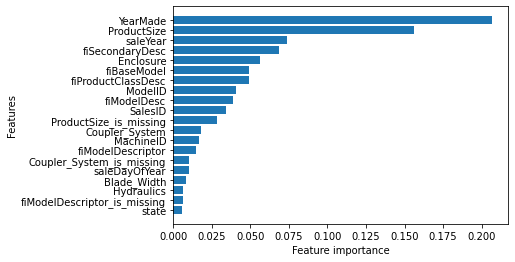

In [96]:
plot_features(X_train.columns, ideal_model.feature_importances_)

In [97]:
df["Enclosure"].value_counts()

OROPS                  177971
EROPS                  141769
EROPS w AC              92601
EROPS AC                   18
NO ROPS                     3
None or Unspecified         2
Name: Enclosure, dtype: int64